In [1]:
import os
import genomepy
import pandas as pd
from torch.nn import functional as F
import torch
import numpy as np

In [2]:
data = pd.read_table("data/pchic/0071_Blood - Non-activated CD4+ Cells_merged_loop.txt")

In [3]:
standard_size = 2048
def expand_enrich_pchic(df):
    df[["bait_frag_chr", "bait_frag_start", "bait_frag_end"]] = df["bait_frag"].str.split(",", expand=True)
    df[["other_frag_chr", "other_frag_start", "other_frag_end"]] = df["other_frag"].str.split(",", expand=True)
    df["bait_size"] = np.abs(df["bait_frag_start"].apply(int) - df["bait_frag_end"].apply(int))
    df["other_size"] = np.abs(df["other_frag_start"].apply(int) - df["other_frag_end"].apply(int))
    df["bait_frag_midpoint"] = df.apply(lambda x: int((int(x["bait_frag_start"]) + int(x["bait_frag_end"])) / 2), axis=1)
    df["bait_frag_standard_size_start"] = df["bait_frag_midpoint"] - standard_size
    df["bait_frag_standard_size_end"]   = df["bait_frag_midpoint"] + standard_size - 1
    df["other_frag_midpoint"] = df.apply(lambda x: int((int(x["other_frag_start"]) + int(x["other_frag_end"])) / 2), axis=1)
    df["other_frag_standard_size_start"] = df["other_frag_midpoint"] - standard_size
    df["other_frag_standard_size_end"]   = df["other_frag_midpoint"] + standard_size - 1
    negative_starting = df.loc[df["other_frag_standard_size_start"] <= 0, "other_frag_standard_size_start"]
    negative_ending = df.loc[df["other_frag_standard_size_start"] <= 0, "other_frag_standard_size_end"]
    df.loc[negative_starting.index, "other_frag_standard_size_end"] = (negative_ending - negative_starting + 1).apply(int)
    df.loc[negative_starting.index, "other_frag_standard_size_start"] = 1
    return df

In [4]:
expand_enrich_pchic(data)

,bait_frag,other_frag,N_reads,score,bait_gene,bait_gene_strand,oe_gene,oe_gene_strand,bait_closest_gene,bait_closest_gene_strand,...,other_frag_start,other_frag_end,bait_size,other_size,bait_frag_midpoint,bait_frag_standard_size_start,bait_frag_standard_size_end,other_frag_midpoint,other_frag_standard_size_start,other_frag_standard_size_end
0,"chr1,831895,848168","chr1,850619,874081",192,12.48,"RP11-54O7.16,RP11-54O7.1",+,"RP11-54O7.16,RP11-54O7.3,AL645608.1,SAMD11","+,-","RP11-54O7.16,RP11-54O7.1",+,...,850619,874081,16273,23462,840031,837983,842078,862350,860302,864397
1,"chr1,831895,848168","chr1,1206874,1212438",11,5.73,"RP11-54O7.16,RP11-54O7.1",+,"UBE2J2,LINC01786","-,+","RP11-54O7.16,RP11-54O7.1",+,...,1206874,1212438,16273,5564,840031,837983,842078,1209656,1207608,1211703
2,"chr1,927395,936954","chr1,1206874,1212438",23,5.57,"RP11-54O7.17,HES4,ISG15","-,+","UBE2J2,LINC01786","-,+","RP11-54O7.17,HES4,ISG15","-,+",...,1206874,1212438,9559,5564,932174,930126,934221,1209656,1207608,1211703
3,"chr1,943677,957199","chr1,1206874,1212438",20,6.04,"ISG15,RP11-54O7.11,AGRN","+,-","UBE2J2,LINC01786","-,+","RP11-54O7.11,ISG15,AGRN","-,+",...,1206874,1212438,13522,5564,950438,948390,952485,1209656,1207608,1211703
4,"chr1,1005127,1034268","chr1,903641,927394",26,8.61,"RNF223,C1orf159",-,"PLEKHN1,PERM1","+,-","RNF223,C1orf159",-,...,903641,927394,29141,23753,1019697,1017649,1021744,915517,913469,917564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215682,"chrY,22732050,22743996","chrY,23423342,23424529",18,7.24,"KDM5DP1,EIF1AY","-,+",NaN,NaN,"KDM5DP1,EIF1AY","-,+",...,23423342,23424529,11946,1187,22738023,22735975,22740070,23423935,23421887,23425982
215683,"chrY,22732050,22743996","chrY,23424530,23428951",15,6.34,"KDM5DP1,EIF1AY","-,+",NaN,NaN,"KDM5DP1,EIF1AY","-,+",...,23424530,23428951,11946,4421,22738023,22735975,22740070,23426740,23424692,23428787
215684,"chrY,22732050,22743996","chrY,23428952,23431276",18,7.58,"KDM5DP1,EIF1AY","-,+",NaN,NaN,"KDM5DP1,EIF1AY","-,+",...,23428952,23431276,11946,2324,22738023,22735975,22740070,23430114,23428066,23432161
215685,"chrY,22732050,22743996","chrY,23431277,23434441",14,5.51,"KDM5DP1,EIF1AY","-,+",NaN,NaN,"KDM5DP1,EIF1AY","-,+",...,23431277,23434441,11946,3164,22738023,22735975,22740070,23432859,23430811,23434906


In [5]:
genomepy.install_genome("hg19")

13:25:23 | INFO | Downloading assembly summaries from UCSC


Fasta("/home/kacper/.local/share/genomes/hg19/hg19.fa")

In [6]:
hg = genomepy.Genome("hg19")

In [7]:
def fasta_to_ohe_mapping(ascii_dna):
        if ascii_dna == 65:  # A
            return 1
        if ascii_dna == 67:  # C
            return 2
        if ascii_dna == 71:  # G
            return 3
        if ascii_dna == 84:  # T
            return 4
        if ascii_dna == 97:  # a
            return 1
        if ascii_dna == 99:  # c
            return 2
        if ascii_dna == 103: # g
            return 3
        if ascii_dna == 116: # t
            return 4
        return 0 # Nn, anything else

def from_loc_to_ohe(chr, start, end):
    sequence = hg.get_seq(chr, start, end)
    buffer = torch.frombuffer(sequence.seq.encode(), dtype=torch.uint8)
    buffer = buffer.apply_(fasta_to_ohe_mapping)
    atcg_mask = buffer != 0 # 1 if actg, 0 otherwise
    buffer -= atcg_mask * 1 # offset indexing for atcg so it starts at 0 instead of 1
                            # this is needed to have the "others" be a 0000 row in OHE
    return (
        F.one_hot(buffer.long(), num_classes=4).T * atcg_mask # OHE and mask others
    )

In [8]:
df_counterfactuals = expand_enrich_pchic(pd.read_csv("data/intermediates/random_negatives.csv"))

In [9]:
data["factual"] = 1
df_counterfactuals["factual"] = 0

In [10]:
combined = pd.concat((
    data[[
        "bait_frag_chr",
        "bait_frag_standard_size_start", 
        "bait_frag_standard_size_end", 
        "other_frag_chr",
        "other_frag_standard_size_start", 
        "other_frag_standard_size_end", 
        "factual"
    ]],
    df_counterfactuals[[
        "bait_frag_chr",
        "bait_frag_standard_size_start", 
        "bait_frag_standard_size_end", 
        "other_frag_chr",
        "other_frag_standard_size_start", 
        "other_frag_standard_size_end", 
        "factual"
    ]],
))

In [66]:
data_train = combined.sample(frac=0.75)
data_test = combined.drop(data_train.index)
data_train = data_train.reset_index()
data_test = data_test.reset_index()

In [67]:
def make_conv_block():
    return torch.nn.Sequential(
        torch.nn.Conv1d(96, 96, 5, padding=2),
        torch.nn.BatchNorm1d(96),
        torch.nn.ReLU(inplace=True),
        torch.nn.MaxPool1d(2)
    )

In [68]:
def make_conv_stack():
    return torch.nn.Sequential(
        torch.nn.Sequential(
            torch.nn.Conv1d(4, 96, 11, padding=5),
            torch.nn.BatchNorm1d(96),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool1d(2)
        ),
        *[make_conv_block() for _ in range(4)]
    )

In [69]:
class DilatedResidualConvolution(torch.nn.Module):
    def __init__(self, dilation, dropout_rate=0.25):
        super(DilatedResidualConvolution, self).__init__()
        self.dilate_block = torch.nn.Sequential(
            torch.nn.Conv1d(96, 48, 3, padding=dilation, dilation=dilation),
            torch.nn.BatchNorm1d(48),
            torch.nn.ReLU(inplace=True),
        )
        self.return_block = torch.nn.Sequential(
            torch.nn.Conv1d(48, 96, 3, padding=dilation, dilation=dilation),
            torch.nn.BatchNorm1d(96),
            torch.nn.Dropout(dropout_rate)
        )
        self.relu = torch.nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x 
        x = self.dilate_block(x)
        x = self.return_block(x)
        x += identity
        x = self.relu(x)
        return x


In [70]:
def make_dilation_stack():
    return torch.nn.Sequential(
        *[DilatedResidualConvolution(2**i) for i in range(1, 5)]
    )

In [22]:
class PoCNetAkitalike(torch.nn.Module):
    def __init__(self):
        super(PoCNetAkitalike, self).__init__()
        self.bait_block = torch.nn.Sequential(
            make_conv_stack(),
            # make_dilation_stack()
        )
        self.other_block = torch.nn.Sequential(
            make_conv_stack(),
            # make_dilation_stack()
        )
    
        self.fc1 = torch.nn.Linear(2 * 96 * 128, 4096)
        self.fc2 = torch.nn.Linear(4096, 4096)
        self.fc3 = torch.nn.Linear(4096, 1)

    def forward(self, x_1, x_2):
        x_1 = self.bait_block(x_1)
        x_1 = torch.flatten(x_1, start_dim=1)

        x_2 = self.other_block(x_2)
        x_2 = torch.flatten(x_2, start_dim=1)
        
        x = torch.concat((x_1, x_2), dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        # x = F.sigmoid(x)
        return x

In [23]:
model = PoCNetAkitalike().cuda()

In [42]:
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [25]:
def chunk_df(df, n):
    return [df[i:i+n] for i in range(0,df.shape[0],n)]

def from_loc_to_ohe_batch(df, prefix: ["bait", "other"]):
    return torch.stack([
        from_loc_to_ohe(row[f"{prefix}_frag_chr"], row[f"{prefix}_frag_standard_size_start"], row[f"{prefix}_frag_standard_size_end"])
        for _, row in df.iterrows()
    ])

In [43]:
torch.cuda.empty_cache()

In [44]:
model.train(True)
from tqdm.notebook import tqdm

for epoch in range(1, 200):
    model.train(True)
    for batch in tqdm(chunk_df(data_train.sample(frac=1.), 100)):
        optimizer.zero_grad()
        
        bait_ohe = from_loc_to_ohe_batch(batch, "bait")
        other_ohe = from_loc_to_ohe_batch(batch, "other")
        yhat = model.forward(bait_ohe.float().cuda(), other_ohe.float().cuda())
        yhat = yhat.cpu().flatten()
        y = torch.from_numpy(batch["factual"].values).float()
        loss = loss_function(yhat, y)
        loss.backward()
        optimizer.step()
        print(f"Loss: {loss: .5f} Accuracy {sum((F.sigmoid(yhat) >= .5) == y)/len(y):.5f} Ones% {sum((F.sigmoid(yhat) >= .5) == 1)/len(y):.5f}", end="\r")
    print()
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_so_far = 0
        for batch in tqdm(chunk_df(data_test.sample(frac=1.), 100)):        
            bait_ohe = from_loc_to_ohe_batch(batch, "bait")
            other_ohe = from_loc_to_ohe_batch(batch, "other")
            yhat = model.forward(bait_ohe.float().cuda(), other_ohe.float().cuda())
            yhat = yhat.cpu().flatten()
            y = torch.from_numpy(batch["factual"].values).float()
            total_correct += sum((F.sigmoid(yhat) >= .5) == y)
            total_so_far += len(y)
        print(f"{total_correct/total_so_far: .5f}", end="\r")
    print()

  0%|          | 0/4739 [00:00<?, ?it/s]

/home/kacper/.pyenv/versions/3.11.8/lib/python3.11/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Loss:  0.60805 Accuracy 0.71429 Ones% 0.14286


  0%|          | 0/236 [00:00<?, ?it/s]

 0.60662


  0%|          | 0/4739 [00:00<?, ?it/s]

Loss:  0.59937 Accuracy 0.69643 Ones% 0.30357


  0%|          | 0/236 [00:00<?, ?it/s]

 0.60811


  0%|          | 0/4739 [00:00<?, ?it/s]

Loss:  0.33785 Accuracy 0.94643 Ones% 0.35714


  0%|          | 0/236 [00:00<?, ?it/s]

 0.59566


  0%|          | 0/4739 [00:00<?, ?it/s]

Loss:  0.35886 Accuracy 0.83929 Ones% 0.51786


  0%|          | 0/236 [00:00<?, ?it/s]

 0.58890


  0%|          | 0/4739 [00:00<?, ?it/s]

Loss:  0.19438 Accuracy 0.92857 Ones% 0.46429


  0%|          | 0/236 [00:00<?, ?it/s]

 0.58392


  0%|          | 0/4739 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [45]:
model.eval()
yhat_list = []
with torch.no_grad():
        for batch in tqdm(chunk_df(data_test, 100)):        
            bait_ohe = from_loc_to_ohe_batch(batch, "bait")
            other_ohe = from_loc_to_ohe_batch(batch, "other")
            yhat = model.forward(bait_ohe.float().cuda(), other_ohe.float().cuda())
            yhat = yhat.cpu().flatten()
            y = torch.from_numpy(batch["factual"].values).float()
            yhat_list.append(F.sigmoid(yhat))

  0%|          | 0/236 [00:00<?, ?it/s]

In [46]:
np.mean(((torch.cat(yhat_list) >= .5) +0).numpy() == data_test["factual"].values)

0.5865176180558507

In [47]:
from sklearn.metrics import roc_curve, roc_auc_score

In [48]:
roc_auc_score(data_test["factual"].values, torch.cat(yhat_list))

0.5929934751809751

In [49]:
fpr, tpr, thresholds = roc_curve(data_test["factual"].values, torch.cat(yhat_list))

In [50]:
import matplotlib.pyplot as plt

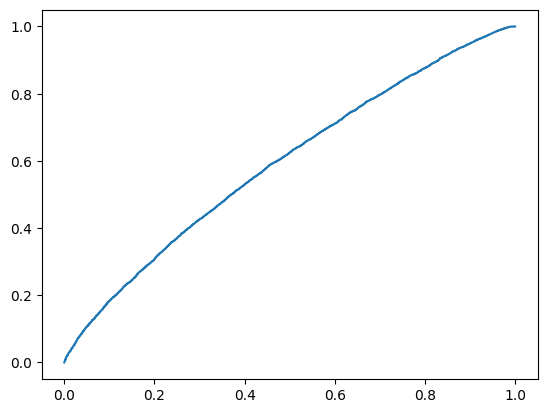

In [51]:
plt.plot(fpr, tpr)

In [52]:
from sklearn.metrics import confusion_matrix
confusion_matrix(
    data_test["factual"].values,
    ((torch.cat(yhat_list) >= .5) +0).numpy()
)

array([[11189,  2103],
       [ 7625,  2610]])

In [53]:
np.sum(data_test["factual"])

10235

In [54]:
from sklearn.metrics import ConfusionMatrixDisplay

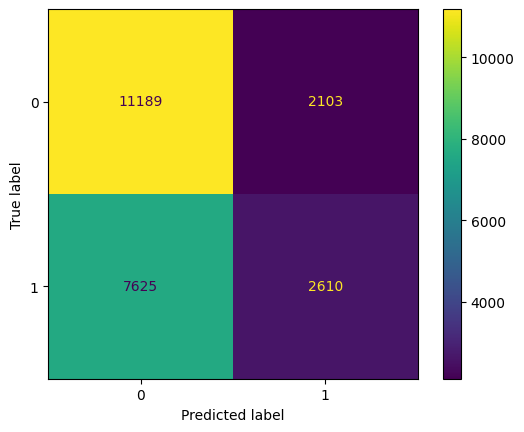

In [55]:
ConfusionMatrixDisplay.from_predictions(    data_test["factual"].values,
    ((torch.cat(yhat_list) >= .5) +0).numpy())

# Train

In [56]:
model.eval()
yhat_list = []
with torch.no_grad():
        for batch in tqdm(chunk_df(data_train, 100)):        
            bait_ohe = from_loc_to_ohe_batch(batch, "bait")
            other_ohe = from_loc_to_ohe_batch(batch, "other")
            yhat = model.forward(bait_ohe.float().cuda(), other_ohe.float().cuda())
            yhat = yhat.cpu().flatten()
            y = torch.from_numpy(batch["factual"].values).float()
            yhat_list.append(F.sigmoid(yhat))

  0%|          | 0/4739 [00:00<?, ?it/s]

/home/kacper/.pyenv/versions/3.11.8/lib/python3.11/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [57]:
np.mean(((torch.cat(yhat_list) >= .5) +0).numpy() == data_train["factual"].values)

0.9742495610480821

In [58]:
from sklearn.metrics import roc_curve, roc_auc_score

In [59]:
roc_auc_score(data_train["factual"].values, torch.cat(yhat_list))

0.9967337632059072

In [60]:
fpr, tpr, thresholds = roc_curve(data_train["factual"].values, torch.cat(yhat_list))

In [61]:
import matplotlib.pyplot as plt

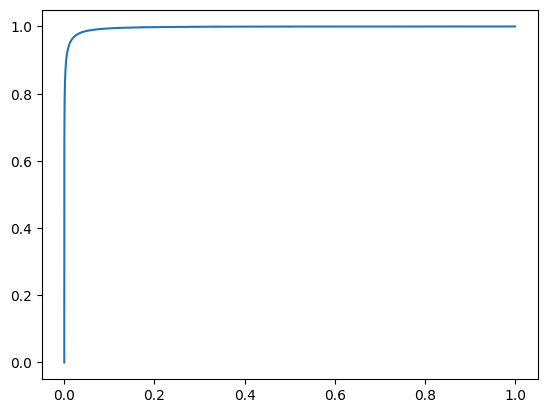

In [62]:
plt.plot(fpr, tpr)

In [63]:
from sklearn.metrics import confusion_matrix
confusion_matrix(
    data_train["factual"].values,
    ((torch.cat(yhat_list) >= .5) +0).numpy()
)

array([[262363,   6041],
       [  6161, 199291]])

In [64]:
from sklearn.metrics import ConfusionMatrixDisplay

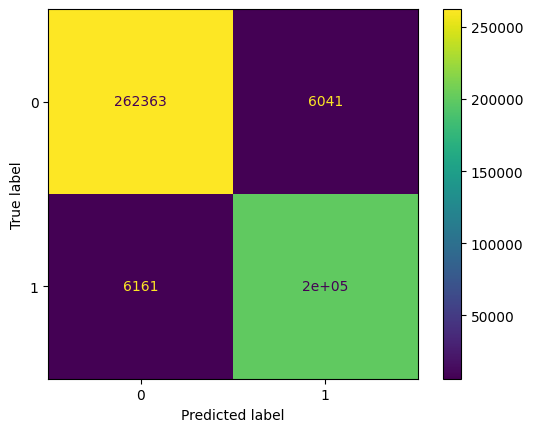

In [65]:
ConfusionMatrixDisplay.from_predictions(    data_train["factual"].values,
    ((torch.cat(yhat_list) >= .5) +0).numpy())

# TRy no chrom

In [71]:
model = PoCNetAkitalike().cuda()

In [72]:
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [73]:
def chunk_df(df, n):
    return [df[i:i+n] for i in range(0,df.shape[0],n)]

def from_loc_to_ohe_batch(df, prefix: ["bait", "other"]):
    return torch.stack([
        from_loc_to_ohe(row[f"{prefix}_frag_chr"], row[f"{prefix}_frag_standard_size_start"], row[f"{prefix}_frag_standard_size_end"])
        for _, row in df.iterrows()
    ])

In [74]:
torch.cuda.empty_cache()

In [ ]:
model.train(True)
from tqdm.notebook import tqdm

for epoch in range(1, 200):
    model.train(True)
    for batch in tqdm(chunk_df(data_train.sample(frac=1.), 100)):
        optimizer.zero_grad()
        
        bait_ohe = from_loc_to_ohe_batch(batch, "bait")
        other_ohe = from_loc_to_ohe_batch(batch, "other")
        yhat = model.forward(bait_ohe.float().cuda(), other_ohe.float().cuda())
        yhat = yhat.cpu().flatten()
        y = torch.from_numpy(batch["factual"].values).float()
        loss = loss_function(yhat, y)
        loss.backward()
        optimizer.step()
        print(f"Loss: {loss: .5f} Accuracy {sum((F.sigmoid(yhat) >= .5) == y)/len(y):.5f} Ones% {sum((F.sigmoid(yhat) >= .5) == 1)/len(y):.5f}", end="\r")
    print()
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_so_far = 0
        for batch in tqdm(chunk_df(data_test.sample(frac=1.), 100)):        
            bait_ohe = from_loc_to_ohe_batch(batch, "bait")
            other_ohe = from_loc_to_ohe_batch(batch, "other")
            yhat = model.forward(bait_ohe.float().cuda(), other_ohe.float().cuda())
            yhat = yhat.cpu().flatten()
            y = torch.from_numpy(batch["factual"].values).float()
            total_correct += sum((F.sigmoid(yhat) >= .5) == y)
            total_so_far += len(y)
        print(f"{total_correct/total_so_far: .5f}", end="\r")
    print()

  0%|          | 0/3731 [00:00<?, ?it/s]

/home/kacper/.pyenv/versions/3.11.8/lib/python3.11/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Loss:  0.55821 Accuracy 0.72973 Ones% 0.24324


  0%|          | 0/434 [00:00<?, ?it/s]

 0.68775


  0%|          | 0/3731 [00:00<?, ?it/s]

Loss:  0.64393 Accuracy 0.67568 Ones% 0.35135


  0%|          | 0/434 [00:00<?, ?it/s]

 0.66521


  0%|          | 0/3731 [00:00<?, ?it/s]

Loss:  0.62486 Accuracy 0.59459 Ones% 0.43243


  0%|          | 0/434 [00:00<?, ?it/s]

 0.68826


  0%|          | 0/3731 [00:00<?, ?it/s]

Loss:  0.35682 Accuracy 0.94595 Ones% 0.43243


  0%|          | 0/434 [00:00<?, ?it/s]

 0.67642


  0%|          | 0/3731 [00:00<?, ?it/s]

Loss:  0.42587 Accuracy 0.81081 Ones% 0.35135


  0%|          | 0/434 [00:00<?, ?it/s]

 0.72806


  0%|          | 0/3731 [00:00<?, ?it/s]

Loss:  0.35821 Accuracy 0.83784 Ones% 0.27027


  0%|          | 0/434 [00:00<?, ?it/s]

 0.74261


  0%|          | 0/3731 [00:00<?, ?it/s]

Loss:  0.24849 Accuracy 0.89189 Ones% 0.43243


  0%|          | 0/434 [00:00<?, ?it/s]

 0.72062


  0%|          | 0/3731 [00:00<?, ?it/s]

Loss:  0.26175 Accuracy 0.91892 Ones% 0.45946


  0%|          | 0/434 [00:00<?, ?it/s]

 0.72834


  0%|          | 0/3731 [00:00<?, ?it/s]

Loss:  0.07642 Accuracy 0.97297 Ones% 0.27027


  0%|          | 0/434 [00:00<?, ?it/s]

 0.76015


  0%|          | 0/3731 [00:00<?, ?it/s]

Loss:  0.10946 Accuracy 0.97297 Ones% 0.48649


  0%|          | 0/434 [00:00<?, ?it/s]

 0.74602


  0%|          | 0/3731 [00:00<?, ?it/s]

Loss:  0.02664 Accuracy 1.00000 Ones% 0.43243


  0%|          | 0/434 [00:00<?, ?it/s]

 0.71626


  0%|          | 0/3731 [00:00<?, ?it/s]

Loss:  0.10002 Accuracy 0.94595 Ones% 0.35135


  0%|          | 0/434 [00:00<?, ?it/s]

 0.70112


  0%|          | 0/3731 [00:00<?, ?it/s]

Loss:  0.02762 Accuracy 1.00000 Ones% 0.51351


  0%|          | 0/434 [00:00<?, ?it/s]

 0.73178


  0%|          | 0/3731 [00:00<?, ?it/s]

Loss:  0.00511 Accuracy 1.00000 Ones% 0.37838


  0%|          | 0/434 [00:00<?, ?it/s]

 0.74452


  0%|          | 0/3731 [00:00<?, ?it/s]

Loss:  0.03315 Accuracy 1.00000 Ones% 0.40541


  0%|          | 0/434 [00:00<?, ?it/s]

 0.71666


  0%|          | 0/3731 [00:00<?, ?it/s]

Loss:  0.03029 Accuracy 1.00000 Ones% 0.32432


  0%|          | 0/434 [00:00<?, ?it/s]

 0.75517


  0%|          | 0/3731 [00:00<?, ?it/s]

Loss:  0.01624 Accuracy 1.00000 Ones% 0.45946


  0%|          | 0/434 [00:00<?, ?it/s]

 0.74454


  0%|          | 0/3731 [00:00<?, ?it/s]

In [45]:
model.eval()
yhat_list = []
with torch.no_grad():
        for batch in tqdm(chunk_df(data_test, 100)):        
            bait_ohe = from_loc_to_ohe_batch(batch, "bait")
            other_ohe = from_loc_to_ohe_batch(batch, "other")
            yhat = model.forward(bait_ohe.float().cuda(), other_ohe.float().cuda())
            yhat = yhat.cpu().flatten()
            y = torch.from_numpy(batch["factual"].values).float()
            yhat_list.append(F.sigmoid(yhat))

  0%|          | 0/236 [00:00<?, ?it/s]

In [46]:
np.mean(((torch.cat(yhat_list) >= .5) +0).numpy() == data_test["factual"].values)

0.5865176180558507

In [47]:
from sklearn.metrics import roc_curve, roc_auc_score

In [48]:
roc_auc_score(data_test["factual"].values, torch.cat(yhat_list))

0.5929934751809751

In [49]:
fpr, tpr, thresholds = roc_curve(data_test["factual"].values, torch.cat(yhat_list))

In [50]:
import matplotlib.pyplot as plt

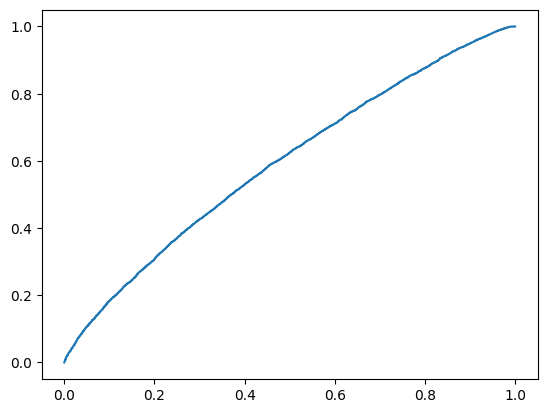

In [51]:
plt.plot(fpr, tpr)

In [52]:
from sklearn.metrics import confusion_matrix
confusion_matrix(
    data_test["factual"].values,
    ((torch.cat(yhat_list) >= .5) +0).numpy()
)

array([[11189,  2103],
       [ 7625,  2610]])

In [53]:
np.sum(data_test["factual"])

10235

In [54]:
from sklearn.metrics import ConfusionMatrixDisplay

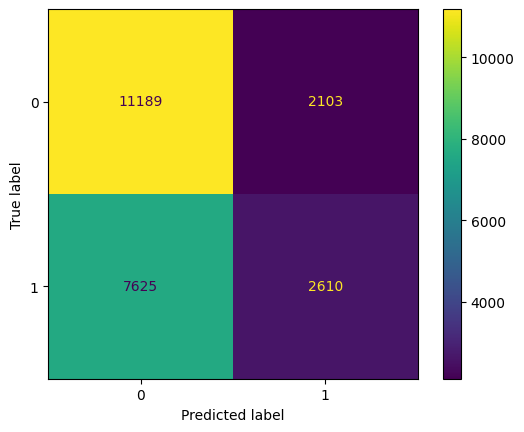

In [55]:
ConfusionMatrixDisplay.from_predictions(    data_test["factual"].values,
    ((torch.cat(yhat_list) >= .5) +0).numpy())

In [ ]:
%%bash
git add .
git commit -m "lol"
git push